In [1]:
%matplotlib inline
# Library/package imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression, ElasticNetCV, BayesianRidge, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot
#from pandas.plotting import scatter_matrix (to make scatter plots?)
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr, spearmanr, mode
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score #To assess the overall accuray of the model (R2 is the fraction of variance explained)
from tqdm.notebook import tqdm
import seaborn as sns;
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from learning_to_rank import LTRPairwise
from sklearn.svm import SVC, LinearSVC

In [2]:
# import datafile with all variables used for Regularization
features = pd.read_csv(r"C:/Users/meike/OneDrive/Documenten/Python Scripts/Data sheets/features_alldata.csv")  # features all data
outcome = pd.read_csv(r"C:/Users/meike/OneDrive/Documenten/Python Scripts/Data sheets/CAMS_alldata.csv")       # CAMS score
sids = pd.read_csv(r"C:/Users/meike/OneDrive/Documenten/Python Scripts/Data sheets/subjectIDs_alldata.csv")    # subject IDs

Xnames = features.columns
y = outcome.values.flatten()
X = features.values
sids=sids.values
print(np.mean(np.isinf(X))) 
df_Xnames = pd.DataFrame(data={'name':Xnames})
# shape
print(X.shape) #check dimensions
print(y.shape)

0.0
(373, 1189)
(373,)


In [3]:
import warnings
warnings.filterwarnings("ignore")
# define the Learning to Rank model
def myfit(X, y, sids, n_features_step1, random_state=2019):
    coefs = []
    X = (X-X.mean(axis=0)) / X.std(axis=0) #normalization/standardization --> results in some NaN values (only for min fooof bw so removed this feature)
   
    print('X shape', X.shape)
    isXnan = np.isnan(X).any()
    print('X is nan',isXnan)
    
    X=np.delete(X,778,1)
    Xnames_final=np.delete(Xnames,778)
    print('size Xnames',Xnames_final.shape)
    print('X new shape',X.shape)

    cvf = 10
    k_fold = StratifiedKFold(cvf, shuffle=True)
    mses = []
    mses_inner_loop = []
    alphas = []
    ytes = []        # y-test values
    yptes = []       # predicted y values 
    sids_tes = []
    bestparam = []
    # split data in train set and test set
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        X_train = X[train]
        X_test = X[test] 
        y_train = y[train]
        yte = y[test]
        sids_te = sids[test]
        print('X_train shape', X_train.shape)
        
        pvals = []
        for i in range(X_train.shape[1]): #i in tqdm(range(X_train.shape[1])):
            # check if the i-th feature is binary
            #X[:,i]
            pval = spearmanr(X_train[:,i], y_train)[1]
            pvals.append(pval)
                            
        pvals = np.array(pvals)
        select_ids = np.sort(np.argsort(pvals)[:n_features_step1])      
        print('fold', k+1)
        print('before univariate selection', X_train.shape[1])
        X_train = X_train[:,select_ids]
        X_test = X_test[:,select_ids]
        print('after univariate selection', X_train.shape[1])
        
        #X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        #print('new shape training set', X_train.shape)
        
        # do LTR 
        LTR = LTRPairwise(estimator=LinearSVC(penalty='l2')) 
        LTR_cv = GridSearchCV(LTR,
                             {'estimator__C':[0.01,0.05,0.1,0.15,0.2],#[0.01,0.1,0.2,0.5],   #estimator__C':[0.1,1,10,100],
                              },
                             n_jobs=6, cv=cvf)
        LTR_cv.fit(X_train, y_train)
        ypte = LTR_cv.predict(X_test)
        score = np.mean((yte - ypte)**2)
        ytes.extend(yte)
        yptes.extend(ypte)
        sids_tes.extend(sids_te)
        mses.append(score)
        bestparam.append(LTR_cv.best_params_['estimator__C'])
            
    mean_mse = np.median(mses)        
    mean_C = np.median(bestparam)      
    
    # now we do one last LTR, where we use the mean C as C --> and this on the whole data
    pvals = []
    for i in range(X.shape[1]):
        # check if the i-th feature is binary
        # X[:,i]
        pval = spearmanr(X[:,i], y)[1] 
        pvals.append(pval)
            
    pvals = np.array(pvals)
    select_ids=np.sort(np.argsort(pvals))
    select_ids = np.sort(np.argsort(pvals)[:n_features_step1]) 
    Xnames2 = Xnames_final[select_ids]
    X = X[:, select_ids]
    
    LTR2 =LTRPairwise (estimator=LinearSVC(penalty='l2', C=mean_C))
    LTR2.fit(X, y)
  
    print('mses',mses)                     #mses for all folds
    print('mean mse',mean_mse)             #mean mse
    print('bestparam',bestparam)
    print('mean C',mean_C)
    print('LTR coefficients',LTR2.estimator.coef_)
    
    return LTR2.estimator.coef_, mean_mse, yptes, ytes, sids_tes, Xnames2  

In [4]:
# do bootstrap to get the confidence interval around the coefs 
np.random.seed(2019)
n_iterations = 0#1000
n_size = int(len(features) * 0.50)
# run bootstrap
stats = []
N = len(X) 
coefs = []
mses  = []
alphas = []

# should try different values from a list (it must be <#patients=172)
n_features_step1 = 65 

for i in range(n_iterations+1):
    
    #to check how far your model is, you can let it print each cycle
    #if i%1==0:
    print(i)
    
    if i==0:
        Xbt = X
        ybt = y
        sidsbt = sids
    else:
        # use the bootstrapping ids to index X and y
        # generate bootstrapping ids
        ids = np.random.choice(N, N, replace=True)
        Xbt = X[ids]
        ybt = y[ids]
        sidsbt = sids[ids]
    
    # fit the model using Xbt and ybt
    coef, mse, yptes_, ytes_, sids_tes_, Xnames2_  = myfit(Xbt, ybt, sidsbt, n_features_step1) 
    if i==0:
        yptes = yptes_ #predicted test values
        ytes = ytes_   #true test values
        sids_tes = sids_tes_
        Xnames2 = Xnames2_
        #print('Xnames2.shape = ', Xnames2.shape)
        
    # append to coefs
    coefs.append(coef)
    mses.append(mse)
    
# compute the upper and lower bound for the confidence interval of each coef
#alpha = 0.95
#p = ((1.0-alpha)/2.0) * 100
#lower = np.percentile(coefs, p, axis=0)
#p = (alpha+((1.0-alpha)/2.0)) * 100
#upper = np.percentile(coefs, p, axis=0)

coefs = [x.flatten() for x in coefs]

print('coefs[0].shape', coefs[0].shape)
big_ids = np.where(np.abs(coefs[0])>1e-4)[0]
output = (np.c_[np.array(Xnames2)[big_ids], coefs[0][big_ids]]) #, lower[big_ids], upper[big_ids]])

# convert from np.array to pd.dataframe
dataset = pd.DataFrame({'Variable': output[:, 0], 'coefs': output[:, 1]})#, 'lower': output[:, 2], 'upper': output[:, 3]})
print(dataset)
#dataset.to_csv("/Users/lisadummer/Dropbox (Partners HealthCare)/brain_age_computer_files/coefs_NIH_5.csv",index=False)

0
X shape (373, 1189)
X is nan False
size Xnames (1188,)
X new shape (373, 1188)
X_train shape (331, 1188)
fold 1
before univariate selection 1188
after univariate selection 65
X_train shape (332, 1188)
fold 2
before univariate selection 1188
after univariate selection 65
X_train shape (333, 1188)
fold 3
before univariate selection 1188
after univariate selection 65
X_train shape (335, 1188)
fold 4
before univariate selection 1188
after univariate selection 65
X_train shape (336, 1188)
fold 5
before univariate selection 1188
after univariate selection 65
X_train shape (336, 1188)
fold 6
before univariate selection 1188
after univariate selection 65
X_train shape (337, 1188)
fold 7
before univariate selection 1188
after univariate selection 65
X_train shape (339, 1188)
fold 8
before univariate selection 1188
after univariate selection 65
X_train shape (339, 1188)
fold 9
before univariate selection 1188
after univariate selection 65
X_train shape (339, 1188)
fold 10
before univariate sel

In [5]:
# Combine yptes (predicted test outcome values) to feature data frame

# first re-arange yptes based on re-aranging sids_tes to the order of sids
rearange_ids = [sids_tes.index(sid) for sid in sids]
yptes2 = np.array(yptes)[rearange_ids]
ytes2 = np.array(ytes)[rearange_ids]
print('Rearrange ids:',rearange_ids)
print('True CAMS scores:',ytes2)
print('Predicted CAMS scores:',yptes2)
print('Correlation between true and test outcome values:',spearmanr(ytes2, yptes2))

Rearrange ids: [123, 124, 83, 84, 271, 198, 339, 199, 0, 235, 85, 125, 42, 305, 1, 161, 306, 86, 236, 200, 87, 126, 272, 273, 237, 201, 340, 274, 88, 341, 89, 275, 2, 3, 43, 44, 127, 4, 45, 5, 6, 307, 46, 202, 128, 308, 90, 238, 47, 129, 203, 162, 91, 276, 204, 205, 92, 342, 206, 7, 8, 277, 9, 93, 309, 48, 10, 130, 239, 207, 278, 94, 131, 163, 11, 12, 95, 240, 132, 96, 164, 241, 13, 242, 343, 97, 49, 98, 165, 133, 99, 134, 50, 279, 14, 208, 344, 243, 135, 280, 100, 136, 137, 281, 15, 101, 102, 16, 244, 245, 282, 345, 310, 166, 138, 139, 17, 311, 140, 312, 346, 103, 167, 18, 347, 19, 283, 313, 104, 51, 141, 52, 284, 53, 54, 348, 168, 314, 315, 55, 285, 56, 105, 246, 169, 20, 106, 170, 349, 57, 209, 171, 172, 58, 210, 316, 317, 350, 286, 318, 59, 211, 60, 173, 247, 107, 212, 319, 287, 248, 108, 320, 61, 21, 22, 62, 213, 351, 63, 142, 174, 175, 321, 23, 249, 109, 64, 214, 215, 143, 216, 176, 177, 65, 250, 178, 352, 217, 218, 288, 219, 289, 144, 179, 353, 251, 145, 146, 252, 253, 254, 354,

In [6]:
# We use 3 metrics to evaluate the performance
# 1. MSE (but Haoqi prefers RMSE, which is at the same scale as CAM score, but they are equivalent)
# 2. Spearman's correlation
# 3. there is a "regression to mean" problem, which is not reflected in the above 2 metrics, so we need a 3rd metric:
# Spearman's correlation between actual vs (pred-actual)
print('corr',spearmanr(ytes, np.array(yptes)-np.array(ytes)))

# possible ways to reduce "regression to mean" problem
# 1. smaller n_featuers_step1 (optimal value based on mse_inner_loop)
# 2. give higher weights to patients with extremely low/high CAM scores OR repeat these patients multiple times
# 3. do ordinal regression

corr SpearmanrResult(correlation=-0.4261283660592741, pvalue=6.9005328301651786e-18)


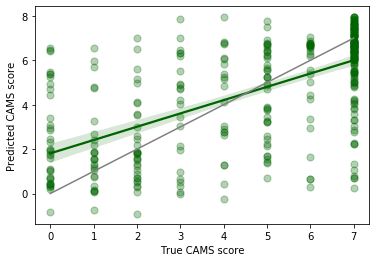

In [29]:
# make scatter plots of actual vs predicted CAM SF score
# x-axis is the actual CAM SF score
# y-axis is the predicted CAM SF score
# note: they should come from the testing folds of the outer loop
#ax = plt.scatter(ytes2, yptes2, s=50, alpha=0.1)
ax = sns.regplot(x=ytes2,y=yptes2,scatter_kws={"s": 50,'alpha':0.3},y_jitter=True,scatter=True,fit_reg=True,color='darkgreen')
ax = plt.plot([0,7], [0,7], color = 'grey') #x_jitter=True
ax = plt.xlabel('True CAMS score')
ax = plt.ylabel('Predicted CAMS score')

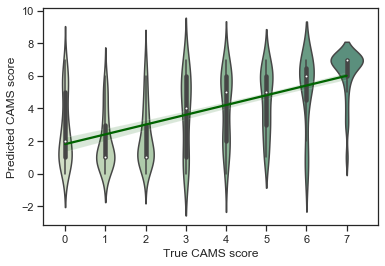

In [30]:
#Violin plot
# Use cubehelix to get a custom sequential palette
rs = np.random.RandomState(0)
n, p = 40, 8
d = rs.normal(0, 2, (n, p))
d += np.log(np.arange(1, p + 1)) * -5 + 10
pal = sns.cubehelix_palette(p, rot=-.5, dark=.5)
sns.set(style="ticks")
sns.violinplot(x=ytes2,y=yptes2,palette=pal)
ax=sns.regplot(x=ytes2,y=yptes2,scatter=False,color='darkgreen')
#ax = plt.plot([0,7], [0,7], color = 'grey') 
ax = plt.xlabel('True CAMS score')
ax = plt.ylabel('Predicted CAMS score')

[[  4  12   5   6   2   2   5   0]
 [  3  13   3   2   2   3   1   0]
 [  4  12   4   5   1   2   3   2]
 [  1   4   3   2   3   2   6   2]
 [  2   1   2   5   0   3   6   2]
 [  2   6   1   6   2   8  10   7]
 [  0   3   2   1   1   4   7   9]
 [  1   6   1  10   3   6  27 110]]
[[11. 33. 14. 17.  6.  6. 14.  0.]
 [11. 48. 11.  7.  7. 11.  4.  0.]
 [12. 36. 12. 15.  3.  6.  9.  6.]
 [ 4. 17. 13.  9. 13.  9. 26.  9.]
 [10.  5. 10. 24.  0. 14. 29. 10.]
 [ 5. 14.  2. 14.  5. 19. 24. 17.]
 [ 0. 11.  7.  4.  4. 15. 26. 33.]
 [ 1.  4.  1.  6.  2.  4. 16. 67.]]


Text(33.0, 0.5, 'Actual CAM-S SF (%)')

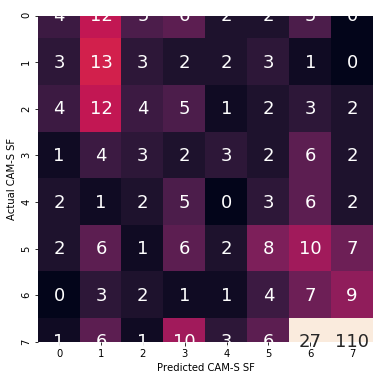

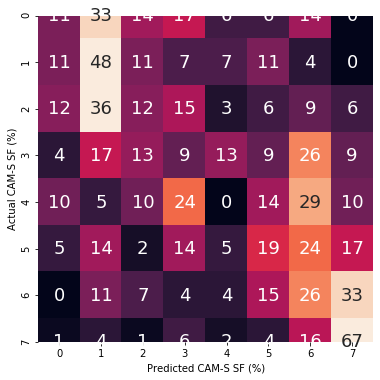

In [8]:
# Make confusion matrix
cf = confusion_matrix(ytes2,yptes2)
cf_normalized = cf/cf.sum(axis=1,keepdims=True)*100
roundcf=np.round(cf_normalized)
print(cf)
print(roundcf)

plt.figure(figsize=(6,6))
#plt.axis('equal')
sns.heatmap(cf, annot=True, vmin=0, vmax=25, fmt='d', cbar=False, annot_kws={'fontsize':18})
plt.xlabel('Predicted CAM-S SF')
plt.ylabel('Actual CAM-S SF')

plt.figure(figsize=(6,6))
#plt.axis('equal')
sns.heatmap(roundcf, annot=True, vmin=0, vmax=35,cbar=False, annot_kws={'fontsize':18})
plt.xlabel('Predicted CAM-S SF (%)')
plt.ylabel('Actual CAM-S SF (%)')

In [7]:
# Accuracy scores
acc0 = np.mean(np.abs(ytes2-yptes2)<=0)
acc1 = np.mean(np.abs(ytes2-yptes2)<=1)
acc2 = np.mean(np.abs(ytes2-yptes2)<=2)
print(acc0)
print(acc1)
print(acc2)

0.3967828418230563
0.6675603217158177
0.7908847184986595


In [10]:
# convert into numpy arrays
ytes_R = np.array(ytes)
yptes_R = np.array(yptes)

ids = (ytes_R<=1)|(ytes_R>=6)
ytes_ext = ytes_R[ids]
yptes_ext = yptes_R[ids]

id2 = sids_tes.index(240)
print(id2)

ytes_true = ytes[id2]
ytes_pred = yptes[id2]
print(ytes_true)
print(ytes_pred)

print(ytes_R)
print(yptes_R)
print(ytes_ext)
print(yptes_ext)

180
7
6
[4 2 7 2 5 7 5 4 6 7 0 5 1 2 0 0 6 7 6 1 1 3 3 7 7 7 7 7 2 7 3 7 7 7 7 4 7
 5 5 7 7 0 3 6 5 7 2 2 0 1 5 1 3 5 7 5 3 2 0 7 7 4 2 4 7 7 1 7 0 7 7 7 0 6
 7 7 7 7 7 7 5 7 6 5 0 5 7 1 2 5 2 4 0 3 6 7 7 2 2 0 1 0 6 3 1 6 7 7 4 3 7
 7 7 5 7 7 7 7 7 7 7 7 7 2 3 2 5 1 0 7 7 5 0 6 5 7 6 7 4 2 7 3 1 5 7 7 7 0
 7 7 1 7 7 7 0 6 7 7 7 7 4 3 5 5 5 5 7 1 7 7 2 2 3 0 6 4 7 7 0 7 7 7 7 0 7
 7 6 7 6 7 7 0 7 7 1 4 1 2 5 3 4 5 6 6 1 6 5 0 2 3 1 2 7 2 5 0 7 7 7 4 7 7
 7 7 0 1 7 7 7 7 7 7 7 7 0 7 3 4 5 6 7 5 0 1 5 2 3 2 1 7 7 1 7 7 2 7 6 5 7
 7 4 7 0 7 7 7 7 0 7 7 6 4 7 5 6 3 5 5 4 0 1 0 2 2 7 0 3 2 7 1 7 7 7 7 7 7
 7 7 7 7 7 7 7 5 6 2 5 6 7 5 2 3 6 7 0 7 5 5 2 4 7 1 7 7 7 7 7 7 7 7 7 0 3
 7 1 0 4 7 7 6 1 4 5 0 1 3 4 5 7 5 2 2 3 7 7 7 7 7 7 6 7 7 0 7 7 7 5 0 7 7
 7 7 2]
[6 6 7 3 6 3 6 3 7 7 4 3 5 1 6 2 7 6 1 1 1 1 6 3 7 6 7 7 1 7 7 7 7 6 7 5 7
 6 1 3 7 1 0 7 0 4 3 7 0 0 7 2 4 3 7 5 5 6 3 0 7 0 3 6 3 7 5 5 0 2 7 6 0 2
 7 7 3 5 7 3 2 7 6 7 3 5 7 1 2 6 1 3 6 4 3 4 7 1 1 5 1 1 6 2 4 7 6 3 2 5 7
 1 7 5 7 

In [36]:
# convert into numpy arrays
ytes_R = np.array(ytes)
yptes_R = np.array(yptes)

ids = (ytes_R<=1)|(ytes_R>=6)
ytes_ext = ytes_R[ids]
yptes_ext = yptes_R[ids]

print(ytes_R)
print(yptes_R)
print(ytes_ext)
print(yptes_ext)

[6 2 4 2 5 5 3 6 2 2 5 7 7 7 0 7 0 7 1 1 7 0 3 7 7 7 5 7 6 7 7 0 4 7 7 7 1
 7 5 5 5 6 5 2 2 1 1 0 3 7 1 2 4 3 7 7 0 7 2 7 7 7 6 7 7 0 7 7 7 6 0 7 4 7
 7 7 3 4 5 2 3 1 2 6 7 5 0 0 6 1 7 2 4 7 7 1 7 7 7 7 7 0 7 7 7 5 7 7 7 7 5
 7 2 0 2 4 7 2 6 0 5 5 5 0 3 0 3 2 3 7 1 7 1 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7
 5 6 4 5 3 7 5 0 1 2 7 6 7 6 3 7 3 2 4 2 7 0 4 7 7 7 7 5 7 7 7 7 1 4 7 5 7
 7 7 0 3 5 5 0 7 7 6 5 3 2 4 1 5 3 2 0 4 7 7 7 7 7 7 7 7 0 7 7 7 1 7 7 2 7
 7 6 6 4 7 7 4 5 0 0 1 2 1 3 5 5 2 7 7 3 2 1 5 5 7 7 7 6 7 7 7 6 6 7 7 7 7
 7 0 7 2 3 7 3 4 5 6 6 5 1 7 5 0 0 6 4 7 5 1 7 1 2 5 2 7 7 7 7 7 7 7 7 7 7
 0 7 7 5 5 1 2 7 0 4 6 5 1 7 0 6 2 5 3 7 7 4 2 6 7 7 7 7 7 3 7 7 1 7 0 7 7
 0 7 7 0 7 6 1 7 5 4 6 5 5 0 1 2 2 7 3 7 6 2 7 7 7 0 7 7 0 7 7 7 3 7 1 7 7
 4 5 7]
[1 3 6 3 4 5 5 5 1 1 7 6 5 1 5 3 3 6 0 1 5 1 5 7 6 4 7 6 6 7 7 1 0 7 7 7 1
 7 1 7 5 6 6 7 1 2 1 2 5 3 3 4 5 6 7 7 1 7 1 7 6 7 6 7 7 0 7 7 7 7 5 7 6 7
 7 7 4 6 6 5 3 1 1 6 7 6 6 3 4 1 7 3 2 7 7 1 7 4 3 7 7 1 7 7 6 5 7 7 3 5 1
 5 0 1 1 2 4 1 6 

In [11]:
# create ROC 
from sklearn.metrics import auc as auc_func

# binarize y: [0,1,2] --> 0, [3,4,5,6,7] --> 1
ytes_ext2 = (ytes_ext>5).astype(int) # for extreme cases
ytes_R2=(ytes_R>0).astype(int) #delirium positive/negative

#Computing auc extreme cases
fprs = []
tprs = []
ppps = []
for thres in np.linspace(yptes_ext.min()-0.001, yptes_ext.max()+0.001, 100):
    ypb = (yptes_ext>=thres).astype(float)
    fpr = np.sum( (ytes_ext2==0) & (ypb==1) ) / np.sum( ytes_ext2==0 )
    tpr = np.sum( (ytes_ext2==1) & (ypb==1) ) / np.sum( ytes_ext2==1 )
    ppp = np.sum( (ytes_ext2==1) & (ypb==1) ) / np.sum( ypb==1 ) #np.sum( (ytes_ext2==1) & (ypb==1) + (ytes_ext2==0) & (ypb==1)) 
    fprs.append(fpr)
    tprs.append(tpr)
    ppps.append(ppp)
fprs = np.array(fprs)
tprs = np.array(tprs)
ppps = np.array(ppps)

ids = (~np.isnan(fprs)) & (~np.isnan(tprs))
auc_ext = auc_func(fprs[ids], tprs[ids])
#ids = (~np.isnan(tprs)) & (~np.isnan(ppps))
ppps[-1] = 1
tprs = np.r_[1,tprs]
ppps = np.r_[0,ppps]
auc_prc = auc_func(tprs, ppps)
print(auc_ext)
print('prc auc:',auc_prc)

#Computing auc delirium pos/neg.
fprs2 = []
tprs2 = []
ppps2 = []
for thres in np.linspace(yptes_R.min()-0.001, yptes_R.max()+0.001, 100):
    ypb2 = (yptes_R>=thres).astype(float)
    fpr2 = np.sum( (ytes_R2==0) & (ypb2==1) ) / np.sum( ytes_R2==0 )
    tpr2 = np.sum( (ytes_R2==1) & (ypb2==1) ) / np.sum( ytes_R2==1 )
    ppp2 = np.sum( (ytes_R2==1) & (ypb2==1) ) / np.sum( ypb2==1 ) 
    fprs2.append(fpr2)
    tprs2.append(tpr2)
    ppps2.append(ppp2)
fprs2 = np.array(fprs2)
tprs2 = np.array(tprs2)
ppps2 = np.array(ppps2) 

ids2 = (~np.isnan(fprs2)) & (~np.isnan(tprs2))
auc_bin = auc_func(fprs2[ids2], tprs2[ids2])
#ids = (~np.isnan(tprs)) & (~np.isnan(ppps))
ppps2[-1] = 1
tprs2 = np.r_[1,tprs2]
ppps2 = np.r_[0,ppps2]
auc_prc_bin = auc_func(tprs2, ppps2)
print(auc_bin)
print('prc auc 0/1:',auc_prc_bin)

0.9185573007562536
prc auc: 0.9747045553476633
0.7792614573030003
prc auc 0/1: 0.9730605260244234


In [38]:
# get the confidence interval in ROC curve (extreme cases)
# get fprs and tprs for ytes and yptes from each boostrapping loop

#Nbt = 1000
#auc_bt = []
# for i in range(Nbt):
#     generate bootstrap dataset with the same size as the actual data using sample with replacement
#     do the same thing in the above cell, using bootstrapped ytes and yptes
#     auc_bt.append(auc)

from sklearn.metrics import roc_auc_score
# do bootstrap to get the confidence interval around AUC 
np.random.seed(2019)
n_iterations = 1000 #10000
#n_size = int(len(ytes_R) * 0.50)

# run bootstrap
stats = []
N = len(ytes_ext) ######
aucs = []
aucs_prc = []

for i in range(n_iterations):
    
    # generate bootstrapping ids
    ids_bts = np.random.choice(N, N, replace=True)
    
    #to check how far your model is, you can let it print each cycle
    #if i%1==0:
    #print(i)
    
    # use the bootstrapping ids to index X and y
    ybt = ytes_ext[ids_bts]
    ypbt = yptes_ext[ids_bts]
    
    # computing auc
    # binarize y: [0,1,2] --> 0, [3,4,5,6,7] --> 1 
    # binarize y: [0,1] vs [6,7]
    ybt = (ybt>5).astype(int)
    
    fprs = []
    tprs = []
    ppps = []
    
    for thres in np.linspace(ypbt.min()-0.001, ypbt.max()+0.001, 100):
        ypb = (ypbt>=thres).astype(float)            #how does this know that we want >5?
        fpr = np.sum( (ybt==0) & (ypb==1) ) / np.sum( ybt==0 )
        tpr = np.sum( (ybt==1) & (ypb==1) ) / np.sum( ybt==1 ) # tpr = sensitivity = recall
        ppp = np.sum( (ybt==1) & (ypb==1) ) / np.sum( ypb==1 ) # gives a few nan values?
        fprs.append(fpr)
        tprs.append(tpr)
        ppps.append(ppp)
        
    auc = auc_func(fprs, tprs)
    auc_prc = auc_func(tprs,ppps)
    #F1=2*(tprs*ppps/(tprs+ppps))
    # append to aucs
    aucs.append(auc)
    aucs_prc.append(auc_prc)
    #F1s.append(F1)

meanauc=np.mean(aucs)
meanauc_prc=np.mean(aucs_prc)
#meanF1=np.mean(F1s)
auc_lb, auc_ub = np.percentile(aucs, (2.5, 97.5))

# get p-value based on boostrap aucs (auc_bt)
# alternative hypothesis (H1): AUC > 0.5
# null hypothesis (H0): AUC <= 0.5 (this is called "one-sided" p-value)
# null hypothesis (H0): AUC = 0.5 (this is called "two-sided" p-value, which are not using)
# p-value is defined as the area left or right to 0.5 (the null hypothesis)
# since the null distribution should sum up to 1, so the area is equal to the fraction of numbers left or right to 0.5
frac_small = np.mean(np.array(aucs)<0.5)
frac_big = np.mean(np.array(aucs)>0.5)

pval = min(frac_small, frac_big)

# since we are using one-sided p-value, we do not need to multiple pval by 2
# pval = pval*2 # only do this if we need two-sided p-value

if pval<0.05:
    significance = '*'
else:
    significance = 'n.s.'

print('mean auc ROC:',meanauc)    
print(auc_lb, auc_ub)
print('pval =',pval)
print(significance)

print('mean auc PRC:',meanauc_prc)
#print('mean F1 score',meanF1)

mean auc ROC: 0.9064465600526315
0.8669348684469654 0.9428881793262355
pval = 0.0
*
mean auc PRC: nan


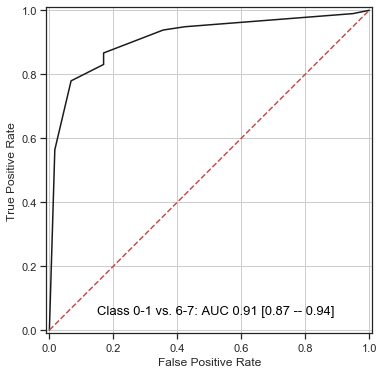

In [40]:
# plot ROC (extreme cases)

plt.figure(figsize=(6,6))
fontsize = 14
font = {'color':  'black',
        'size': 13,}
s = 'Class 0-1 vs. 6-7: AUC %.2f [%.2f -- %.2f]'%(auc_ext, auc_lb, auc_ub)
plt.plot(fprs, tprs, c='k', label = '2')
plt.plot([0,1], [0,1], ls='--', c='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# set title 
#plt.title('E', loc='left', fontsize=fontsize)
#plt.tick_params(labelsize=fontsize)

# set text AUC
plt.text(0.15, 0.05, s , fontdict=font)

# make square
plt.axis('square')

# set gridlines
plt.grid(True)

# set decimals to 1 for x and y axis
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

#plt.savefig('ROCE.png', dpi=600, bbox_inches='tight')
plt.show()